In [38]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
from numpy.random import randn,random,normal,rand
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as ml
import matplotlib.pyplot as plt
%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# GANs - Generative Adversarial Networks
It basically consists of two competing neural networks that are constantly engaged in a fight with each other. These two networks are : the Generator and the Discriminator.
Let us take a common example :

The investigator is the Discriminator, the forger is the Generator.

1. The forger is trying to fool the investigator by generating pictures that almost resemble the original pictures seen by the investigator. 
2. The investigator assigns the pictures labels : 0 for No, 1 for Yes : for each picture generated by the forger. 
3. The result of the investigator is used by the forger as information, to generate better pictures with each pass.
4. This continues till the forger produces an image that fools the  investigator

Expressing in terms of GANs :

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2017/06/11000153/g1.jpg)

1. The Discriminator is trained on original pictures(forward pass). The Generator is frozen(read: no training). 
2. The weights of the Discriminator weights are updated.

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2017/06/14204616/s1.jpg)

3. The Generator is trained(forward pass) and the Discriminator is frozen(only outputs, no training).

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2017/06/14204626/s21.png)

4. The Discriminator is then trained on the noisy data, the wieghts are updated.
5. The Generator weights are updated(depends on the discriminator weights and output).
6. This continues till the epochs are exhausted.

# OBJECTIVE OF THIS NOTEBOOK
### Here, we are building a pair of simple one-layered GANs which generate very basic 2x2 black and white images. The original image reperesents a backslash('\')

![](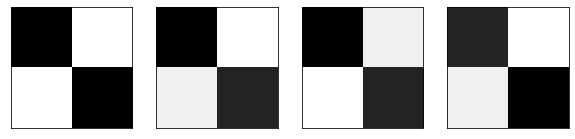%0A)

As it is evident, since the picture is a Backslash, so in the 2 x 2 image matrix, the cells [0][0] and [1][1] (along the main diagonal) will have the highest values (0.7 - 1)(i.e, they'll be the darkest) ; and the other two cells will have low values.

Steps we'll follow :
1. Create the original pictures.
2. Generate noisy data.
3. Build the GAN :
    1. Build the Discriminator class.
    2. Build the Genarator class.
4. Training phase
5. Generation phase
    1. Display the generated images.
    2. Display final weights of the generator and discriminator
6. Plot errors of both discriminator and the generator for all epochs.

# 1. PLOTTING FUNCTION


PLOTTING ORIGINAL IMAGE SAMPLES - 


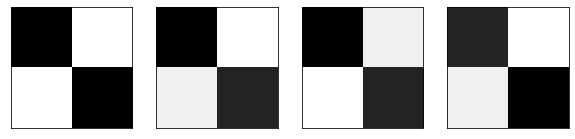

In [39]:
def view_images(matrices,rows,cols):
    fig,axes = plt.subplots(figsize=(10,10),nrows=rows,ncols=cols,sharex=True,sharey=True)
    for axis,image in zip(axes.flatten(),matrices):
        axis.xaxis.set_visible(False)
        axis.yaxis.set_visible(False)
        im = axis.imshow(1-image.reshape((2,2)),cmap='Greys_r')
    return fig,axes

# Viewing sample data
# Original pictures
samples = [np.array([1,0,0,1]),
           np.array([0.9,0.1,0.2,0.8]),
           np.array([0.9,0.2,0.1,0.8]),
           np.array([0.8,0.1,0.2,0.9]),
           np.array([0.8,0.2,0.1,0.9])]
print("PLOTTING ORIGINAL IMAGE SAMPLES - ")
_ = view_images(matrices = samples,rows = 1,cols = 4)

PLOTTING NOISY IMAGE SAMPLES - 


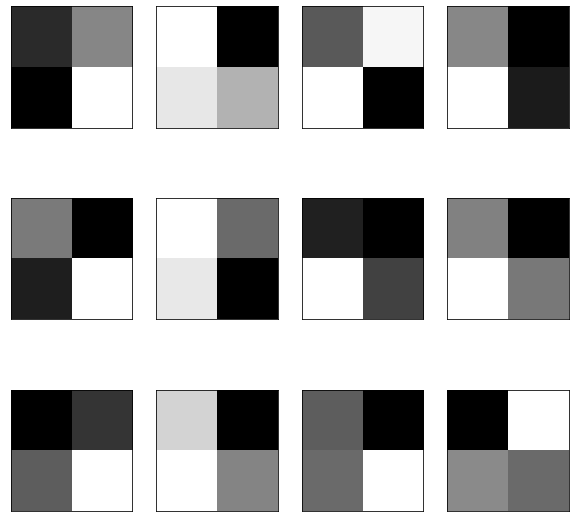

In [40]:
#Viewing sample data
# Noisy data
noise = [np.random.randn(2,2) for i in range(12)]    # 10 images
print("PLOTTING NOISY IMAGE SAMPLES - ")
_ = view_images(matrices = noise,rows = 3,cols = 4)

# 2. BUILDING THE NEURAL NETWORK
Understanding the mathematics behind the neural networks in a GAN

## The Discriminator

![](https://github.com/BALaka-18/gans/blob/master/discriminator.png?raw=true)

Calculating the errors and derivatives for updating the weights during back propagation(Point number 2) using the output from the sigmoid activation function, D(x).

![](https://github.com/BALaka-18/gans/blob/master/discriminator_math.png?raw=true)

### Why do we use the sigmoid and not any other mathematical function ? 
![](https://github.com/BALaka-18/images/blob/master/5.png?raw=true)

This shows that, for outputs closer to 1, the sigmoid function yields higher values. For outputs closer to 0, it yields lower values.

So, a high output of the sigmoid function tells us that the picture is most probably closer to being an original image(basic test)

________________________________________________________________________________________________________________________________________________________________________________

### A little more about the error from images and from noise :

Let us consider the Discriminator's outputs are binary lables : 0 for noise, 1 for real images.

When the label is 1, or, the situation demands 1 as an ideal label(say when real images are passed into the Discriminator), then the error E = -ln(D(x))

![](https://github.com/BALaka-18/images/blob/master/1_2.png?raw=true)

![](https://github.com/BALaka-18/images/blob/master/3.png?raw=true)
________________________________________________________________________________________________________________________________________________________________________________
When the label is 0, or, the situation demands 0 as an ideal label(say when noisy images are passed into the Discriminator), then the error E = -ln(1-D(x))

![](https://github.com/BALaka-18/images/blob/master/2.png?raw=true)

![](https://github.com/BALaka-18/images/blob/master/4.png?raw=true)

In [41]:
# Defining the function for the sigmoid activation function
def sigmoid(x):
    return np.exp(x)/(1.0 + np.exp(x))

# Building the Discriminator class
class Discriminator():
    def __init__(self):
        self.weights = np.array([np.random.normal() for i in range(4)])
        self.bias = np.random.normal()
    # Forward pass
    def forward(self,X):
        return sigmoid(np.dot(X,self.weights) + self.bias)
    # Error calculation from image
    def error_from_image(self,image):
        pred = self.forward(image)
        # We want positive prediction, so E = -ln(D(x)) = -ln(pred)
        return -np.log(pred)
    # Obtaining derivative values before back propagation
    def deriv_from_images(self,image):
        dx = self.forward(image)
        d_wts = -(1-dx)*image
        d_bias = -(1-dx)
        return d_wts,d_bias
    # Updating the weights for Discriminator trained on real images
    def update_from_image(self,x):
        dervs = self.deriv_from_images(x)
        self.weights -= learning_rate*dervs[0]
        self.bias -= learning_rate*dervs[1]
    # Error calculation from noise
    def error_from_noise(self,noise):
        pred = self.forward(noise)
        # We want negative prediction, so E = -ln(1-D(x)) = -ln(1-pred)
        return -np.log(1-pred)
    # Obtaining derivative values fro back propagation (Point no. 4)
    def deriv_from_noise(self,noise):
        dx = self.forward(noise)
        dwts_n = (dx)*noise
        dbias_n = dx
        return dwts_n,dbias_n
    # Updating the weights for Discriminator trained on noisy images
    def update_from_noise(self,noise):
        dervs = self.deriv_from_noise(noise)
        self.weights -= learning_rate*dervs[0]
        self.bias -= learning_rate*dervs[1]

## The Generator

![](https://github.com/BALaka-18/gans/blob/master/generator.png?raw=true)

Calculating the errors and derivatives for updating the weights during back propagation(Point number 2) using the output from the sigmoid activation function, D(x), and also the Generator, G(z)
![](https://github.com/BALaka-18/gans/blob/master/generator_math.png?raw=true)



In [42]:
# Building the Generatoe class
class Generator():
    def __init__(self):
        self.weights = np.array([np.random.normal() for i in range(4)])
        self.bias = np.array([np.random.normal() for i in range(4)])
    # Forward pass
    def forward(self,z):
        return sigmoid(z*self.weights + self.bias)
    # Calculating error in a Generator produced image
    def error(self,z,d):
        x = self.forward(z)
        y = self.forward(x)
        return -np.log(y)
    # Get derivatives wrt weights
    def deriv(self,z,d):
        d_wts = d.weights
        d_bs = d.bias
        x = self.forward(z)
        y = d.forward(x)
        factor = -(1-y)*d_wts*x*(1-x)
        dwts_g = factor*z
        dbs_g = factor
        return dwts_g,dbs_g
    # Updating Discriminator weights
    def update(self,z,d):
        err_before = self.error(z,d)
        ders = self.deriv(z,d)
        self.weights -= learning_rate*ders[0]
        self.bias -= learning_rate*ders[1]
        err_after = self.error(z,d)

# 3. TRAINING THE GAN

In [61]:
np.random.seed(45)        # Settiing seed value

# Set hyperparameters
learning_rate = 0.01
epochs = 25000

# Setting up the GAN
# 1. The Discriminator
D = Discriminator()
# 2. The Generator
G = Generator()

err_D,err_G = [],[]   # To store error values and plot them later.
for e in range(epochs):
    for s in samples:
        # Doing step-by-step
        # 1. Updating D with weights from real image
        D.update_from_image(s)
        # 2. Picking a random value of z to initiate the process of producing a Generator.
        z = rand()
        # 3. Calculate Discriminator error
        ''' Error = -ln(D(x)) - ln(1-D(x)) 
                  = -ln(D(s)) - ln(1-D(z)) '''
        err_D.append(sum(D.error_from_image(s) + D.error_from_noise(z)))
        # 4. Calculate Generator error
        ''' Error = -ln(D(G(z))) '''
        err_G.append(G.error(z,D))
        # 5. Build the fake image
        noise = G.forward(z)
        # 6. Backpropagate to update discriminator weights from fake face
        D.update_from_noise(noise)
        # 7. Backpropagate to update generator weights from fake face
        G.update(z,D)

# 4. GENERATING THE IMAGES
1. Plotting the images
2. Plotting the error vs epoch lapse for both the Discriminator and the Generator
3. Printing out the final weights and bias values of the Discriminator and the Generator

[[0.93837619 0.13902304]
 [0.1919134  0.81719345]] 

[[0.95066388 0.14678532]
 [0.22932152 0.7772908 ]] 

[[0.91772177 0.12928924]
 [0.14984499 0.86113654]] 

[[0.92963217 0.1345075 ]
 [0.1716914  0.83845777]] 



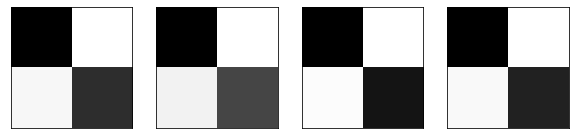

In [68]:
# 1. Plotting
generated_images = []
for i in range(4):
    z = rand()
    generated_image = G.forward(z)
    generated_images.append(generated_image)
_ = view_images(generated_images, 1, 4)

# Printing the matrix values
for img in generated_images:
    print(img.reshape(2,2),"\n")

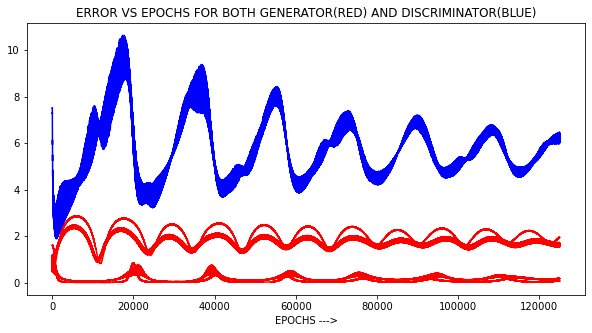

In [69]:
# 2. Plotting the error vs epoch lapse for both the Discriminator and the Generator
plt.figure(figsize=(10,5))
plt.plot(err_G,color='red',label="Generator")
plt.plot(err_D,color='blue',label="Discriminator")
plt.xlabel("EPOCHS --->")
plt.title("ERROR VS EPOCHS FOR BOTH GENERATOR(RED) AND DISCRIMINATOR(BLUE)")
plt.show()

In [71]:
# 3. Printing the weights and bias related to each Network.
# The Discriminator
print("THE DISCRIMINATOR : \nThe final weights = {}\nThe final bias = {}".format(D.weights,D.bias))
print("\nTHE GENERATOR : \nThe final weights = {}\nThe final biases = {}".format(G.weights,G.bias))

THE DISCRIMINATOR : 
The final weights = [-0.25152788 -0.34186464 -0.03561004 -0.17626775]
The final bias = 0.41257507162614176

THE GENERATOR : 
The final weights = [-1.48959401 -0.40111232 -1.42680455  1.5661502 ]
The final biases = [ 2.96642784 -1.75790638 -1.20455641  1.24161663]


#### Source of Inspiration for writing this notebook : Luis Serrano